In [ ]:
import os
import numpy as np
import yaml
import pprint
import pickle
import utils.signals.gps_l1ca as gps_l1ca
import utils.sample_processing.sample_streaming as sample_streaming
import utils.sample_processing.bpsk_acquisition as bpsk_acquisition
import utils.sample_processing.tracking as tracking
import utils

from scipy.constants import speed_of_light

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

In [ ]:
# Get local-data directory for storing downloaded data files
data_dir = os.path.join(os.path.dirname(os.path.dirname(utils.__file__)), "local-data")
os.makedirs(data_dir, exist_ok=True)
raw_collects_dir = os.path.join(data_dir, "raw-collects")
os.makedirs(raw_collects_dir, exist_ok=True)
raw_collect_filenames = sorted(os.listdir(raw_collects_dir))
print(f"Data directory: {data_dir}")
collect_metadata_filepath = os.path.join(raw_collects_dir, "metadata.yml")
with open(collect_metadata_filepath, "r") as f:
    collect_metadata = yaml.safe_load(f)
collect_filepaths = {
    collect_id: os.path.join(raw_collects_dir, collect_info["filename"])
    for collect_id, collect_info in collect_metadata["collections"].items()
}

samp_rate = collect_metadata["samp_rate"]
inter_freq_l1_hz = collect_metadata["bands"]["L1"]["inter_freq"]
sample_params_dict = collect_metadata["sample_params"]
sample_params = sample_streaming.SampleParameters.from_dict(sample_params_dict)
print(f"Sample rate: {samp_rate/1e6} MHz")
pprint.pprint(sample_params)

collect_id_list = sorted(collect_filepaths.keys())
print("Available collects:")
for collect_id in collect_id_list:
    print(f"  {collect_id}: {os.path.basename(collect_filepaths[collect_id])}")

collect_id = collect_id_list[0]
collect_filepath = collect_filepaths[collect_id]
print(f"Using collect ID: {collect_id}")

Data directory: /home/brianbw/projects/fall-2025-lectures/local-data
Sample rate: 25.0 MHz
SampleParameters(bit_depth=4,
                 is_complex=True,
                 is_integer=True,
                 is_signed=True,
                 is_i_lsb=True)
Available collects:
  20220513_173218_USRP2: CO_A2_20220513_173218_000211_G1_B1_USRP2.sc4
Using collect ID: 20220513_173218_USRP2


In [3]:
# Save tracking results from file
tracking_results_directory = os.path.join(data_dir, "tracking-results")
os.makedirs(tracking_results_directory, exist_ok=True)

# Load single file
# tracking_results_version_id = "v1"
# tracking_results_filepath = os.path.join(
#     tracking_results_directory, f"{collect_id}.{tracking_results_version_id}.pkl"
# )
# if not os.path.exists(tracking_results_filepath):
#     raise FileNotFoundError(
#         f"Tracking results file not found: {tracking_results_filepath}"
#     )
# with open(tracking_results_filepath, "rb") as f:
#     tracking_loop_params: tracking.TrackingLoopParameters = pickle.load(f)
#     tracking_outputs: dict[str, tracking.SignalTrackingOutputs] = pickle.load(f)

all_available_tracking_output_files = os.listdir(tracking_results_directory)
collect_tracking_output_files = [
    fn
    for fn in all_available_tracking_output_files
    if fn.startswith(f"{collect_id}.") and fn.endswith(".pkl")
]
print("Available tracking output files for this collect:")
for fn in collect_tracking_output_files:
    print(f"  {fn}")

TrackingOutputsDict = dict[str, tracking.SignalTrackingOutputs]
all_tracking_loop_params: dict[str, tracking.TrackingLoopParameters] = {}
all_tracking_outputs: dict[str, TrackingOutputsDict] = {}
for fn in collect_tracking_output_files:
    version_id = fn.split(".")[-2]
    tracking_results_filepath = os.path.join(tracking_results_directory, fn)
    with open(tracking_results_filepath, "rb") as f:
        tracking_loop_params: tracking.TrackingLoopParameters = pickle.load(f)
        tracking_outputs: dict[str, tracking.SignalTrackingOutputs] = pickle.load(f)
    all_tracking_loop_params[version_id] = tracking_loop_params
    all_tracking_outputs[version_id] = tracking_outputs

Available tracking output files for this collect:
  20220513_173218_USRP2.v5.pkl
  20220513_173218_USRP2.v3.pkl
  20220513_173218_USRP2.vT2_code-offset.pkl
  20220513_173218_USRP2.vT1_30Hz.pkl
  20220513_173218_USRP2.v_30_2_imre_discr.pkl
  20220513_173218_USRP2.v4.pkl
  20220513_173218_USRP2.v2.pkl
  20220513_173218_USRP2.v1.pkl


In [4]:
all_tracking_version_ids = sorted(all_tracking_outputs.keys())
all_tracking_PLL_bandwidths = [
    all_tracking_loop_params[vid].PLL_bandwidth_hz for vid in all_tracking_version_ids
]
all_tracking_DLL_bandwidths = [
    all_tracking_loop_params[vid].DLL_bandwidth_hz for vid in all_tracking_version_ids
]
print("Available tracking results versions:")
for vid, pll_bw, dll_bw in zip(all_tracking_version_ids, all_tracking_PLL_bandwidths, all_tracking_DLL_bandwidths):
    print(f"  Version ID: {vid}, PLL BW: {pll_bw} Hz, DLL BW: {dll_bw} Hz")

# plot_tracking_version_ids = all_tracking_version_ids
plot_tracking_version_ids = ["v5", "v4", "v1", "v3", "v2"]

Available tracking results versions:
  Version ID: v1, PLL BW: 30.0 Hz, DLL BW: 5.0 Hz
  Version ID: v2, PLL BW: 90.0 Hz, DLL BW: 5.0 Hz
  Version ID: v3, PLL BW: 60.0 Hz, DLL BW: 5.0 Hz
  Version ID: v4, PLL BW: 20.0 Hz, DLL BW: 5.0 Hz
  Version ID: v5, PLL BW: 10.0 Hz, DLL BW: 5.0 Hz
  Version ID: vT1_30Hz, PLL BW: 30.0 Hz, DLL BW: 5.0 Hz
  Version ID: vT2_code-offset, PLL BW: 30.0 Hz, DLL BW: 5.0 Hz
  Version ID: v_30_2_imre_discr, PLL BW: 30.0 Hz, DLL BW: 5.0 Hz


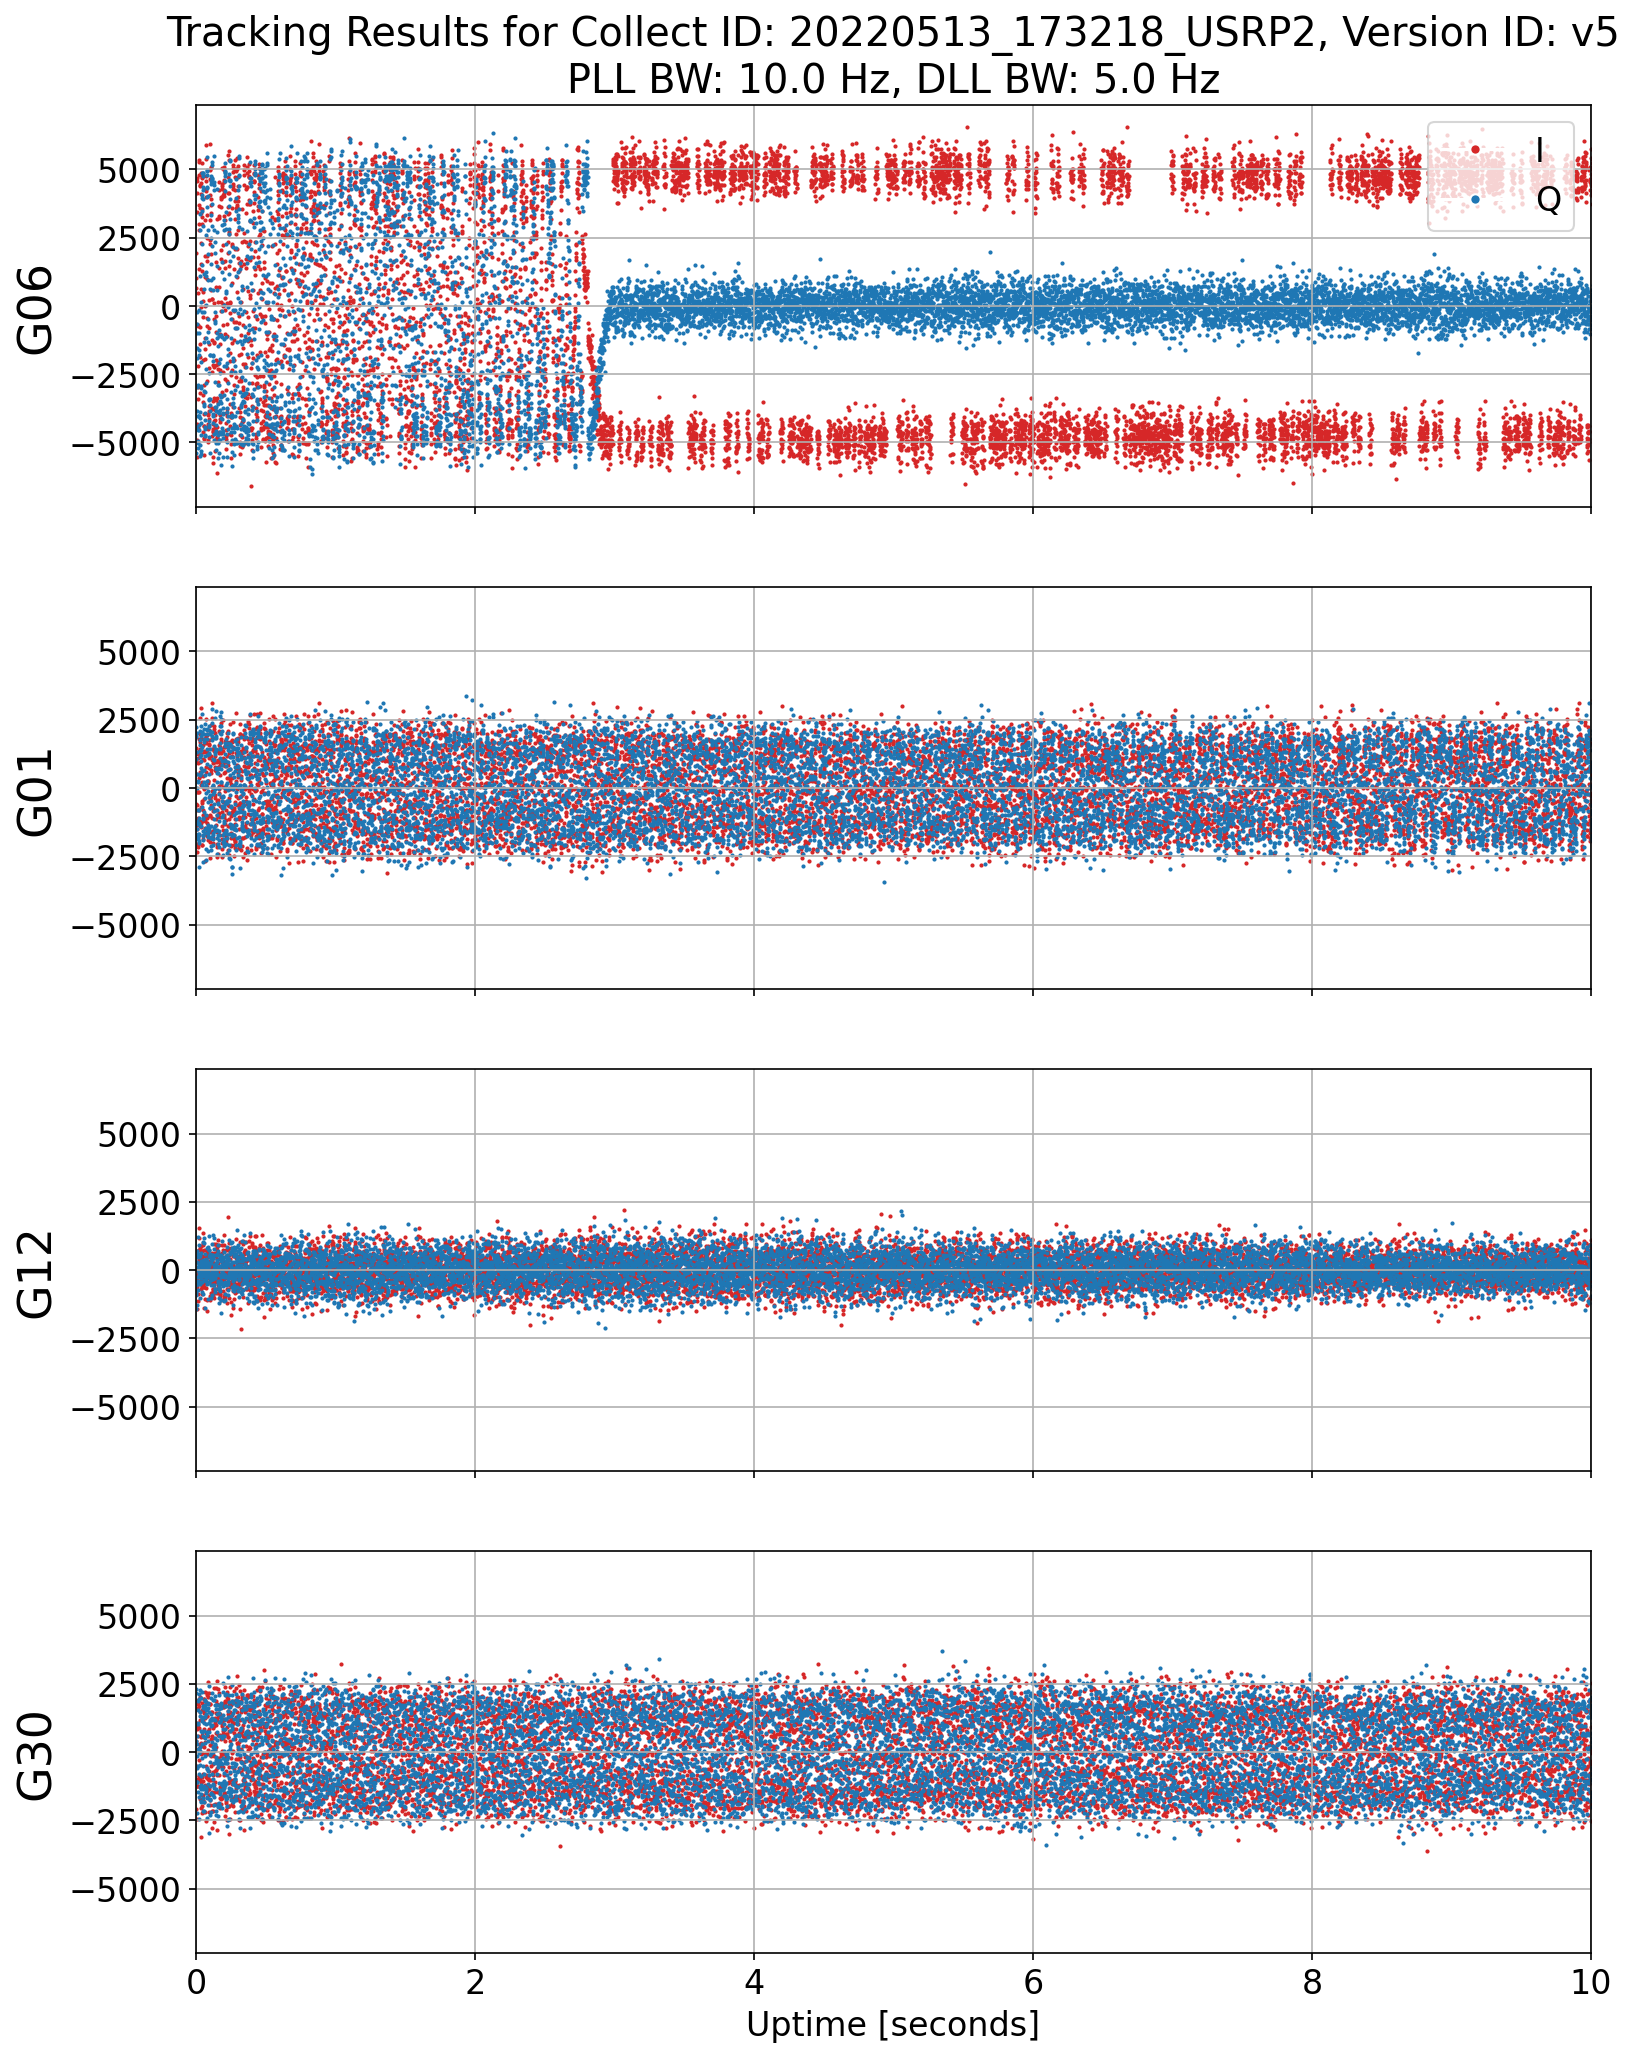

In [5]:
# Plot prompt I/Q for each signal for particular tracking version
plot_tracking_version_id = plot_tracking_version_ids[0]
tracking_loop_params = all_tracking_loop_params[plot_tracking_version_id]
tracking_outputs = all_tracking_outputs[plot_tracking_version_id]

plot_sig_ids = sorted(tracking_outputs.keys())
# plot_sig_ids = ["G06", "G14", "G17", "G19", "G28"]
# plot_sig_ids = ["G01", "G02", "G03", "G11", "G13", "G24"]
plot_sig_ids = ["G06", "G01", "G12", "G30"]

fig = plt.figure(figsize=(12, 16), dpi=150)
axes = fig.subplots(len(plot_sig_ids), 1, sharex=True, sharey=True)
for i, sig_id in enumerate(plot_sig_ids):
    tracking_output = tracking_outputs[sig_id]
    prompt = tracking_output.prompt_corr   
    plot_time = tracking_output.uptime_seconds

    ax = axes[i]
    ax.scatter(plot_time, prompt.real, s=1, color="tab:red")
    ax.scatter(plot_time, prompt.imag, s=1, color="tab:blue")
    # ax.text(0.02, 0.89, f"{sig_id}", fontsize=18, transform=ax.transAxes)
    ax.grid(True)
    ax.set_ylabel(f"{sig_id}", fontsize=22)
    ax.set_xlim(0, 10)

axes[0].set_title(f"Tracking Results for Collect ID: {collect_id}, Version ID: {plot_tracking_version_id}\n"
             f"PLL BW: {tracking_loop_params.PLL_bandwidth_hz} Hz, DLL BW: {tracking_loop_params.DLL_bandwidth_hz} Hz")
axes[-1].set_xlabel("Uptime [seconds]")
# axes[len(axes)//2].set_ylabel("Prompt Correlation")
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:red', markersize=5, label='I'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=5, label='Q')]
axes[0].legend(handles=handles, loc='upper right')
plt.show()

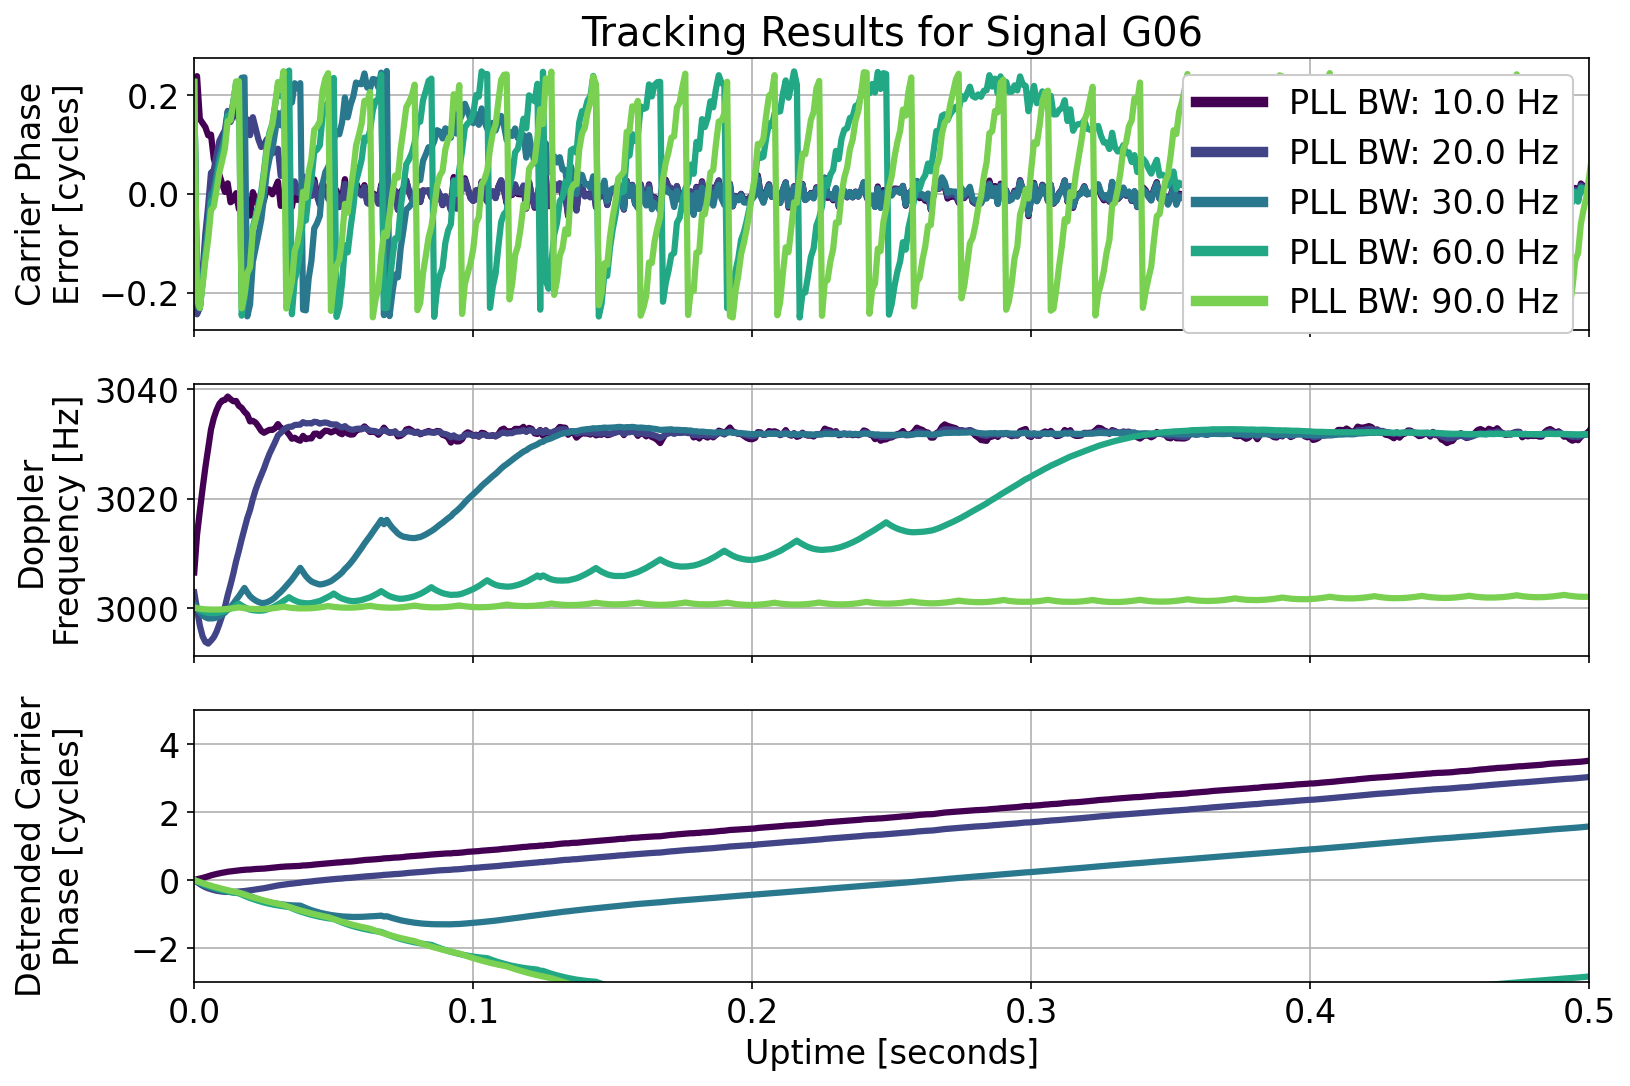

In [6]:
# Select one sig_id and plot for each tracking version
plot_sig_id = plot_sig_ids[0]
fig = plt.figure(figsize=(12, 8), dpi=150)
axes = fig.subplots(3, 1, sharex=True)

cmap = plt.get_cmap("viridis")
for i, tracking_version_id in enumerate(plot_tracking_version_ids[::-1]):
    tracking_loop_params = all_tracking_loop_params[tracking_version_id]
    tracking_outputs = all_tracking_outputs[tracking_version_id]
    tracking_output = tracking_outputs[plot_sig_id]

    plot_time = tracking_output.uptime_seconds
    carr_phase_errors_cycles = tracking_output.carr_phase_errors_cycles
    code_phase_errors_chips = tracking_output.code_phase_errors_chips
    doppler_freq_hz = tracking_output.doppler_freq_hz
    carr_phase_cycles = tracking_output.carr_phase_cycles

    ave_doppler_hz = np.mean(doppler_freq_hz)
    detr_carr_phase_cycles = carr_phase_cycles - ave_doppler_hz * plot_time
    detr_carr_phase_cycles -= detr_carr_phase_cycles[0]

    color = cmap(i / len(plot_tracking_version_ids))

    # Plot phase error, doppler, and detr. carrier phase
    ax = axes[0]
    ax.plot(plot_time, carr_phase_errors_cycles, color=color, lw=3)
    ax.set_ylabel("Carrier Phase\nError [cycles]")
    ax.set_title(f"Tracking Results for Signal {plot_sig_id}")

    ax = axes[1]
    ax.plot(plot_time, doppler_freq_hz, color=color, lw=3)
    ax.set_ylabel("Doppler\nFrequency [Hz]")

    ax = axes[2]
    ax.plot(plot_time, detr_carr_phase_cycles, color=color, lw=3)
    ax.set_ylabel("Detrended Carrier\nPhase [cycles]")
    ax.set_xlabel("Uptime [seconds]")

for ax in axes:
    ax.grid()
handles = []
for i in range(len(plot_tracking_version_ids)):
    tracking_version_id = plot_tracking_version_ids[i]
    tracking_loop_params = all_tracking_loop_params[tracking_version_id]
    label = (
        # f"Version ID: {plot_tracking_version_ids[i]}, "
        f"PLL BW: {tracking_loop_params.PLL_bandwidth_hz} Hz"
        # f"DLL BW: {tracking_loop_params.DLL_bandwidth_hz} Hz"
    )
    handles.append(
        plt.Line2D(
            [0], [0], color=cmap(i / len(plot_tracking_version_ids)), lw=5, label=label
        )
    )
axes[0].legend(handles=handles, loc="upper right", framealpha=1)

axes[0].set_xlim(0, 0.5)
axes[-1].set_ylim(-3, 5)
fig.align_labels()
plt.show()

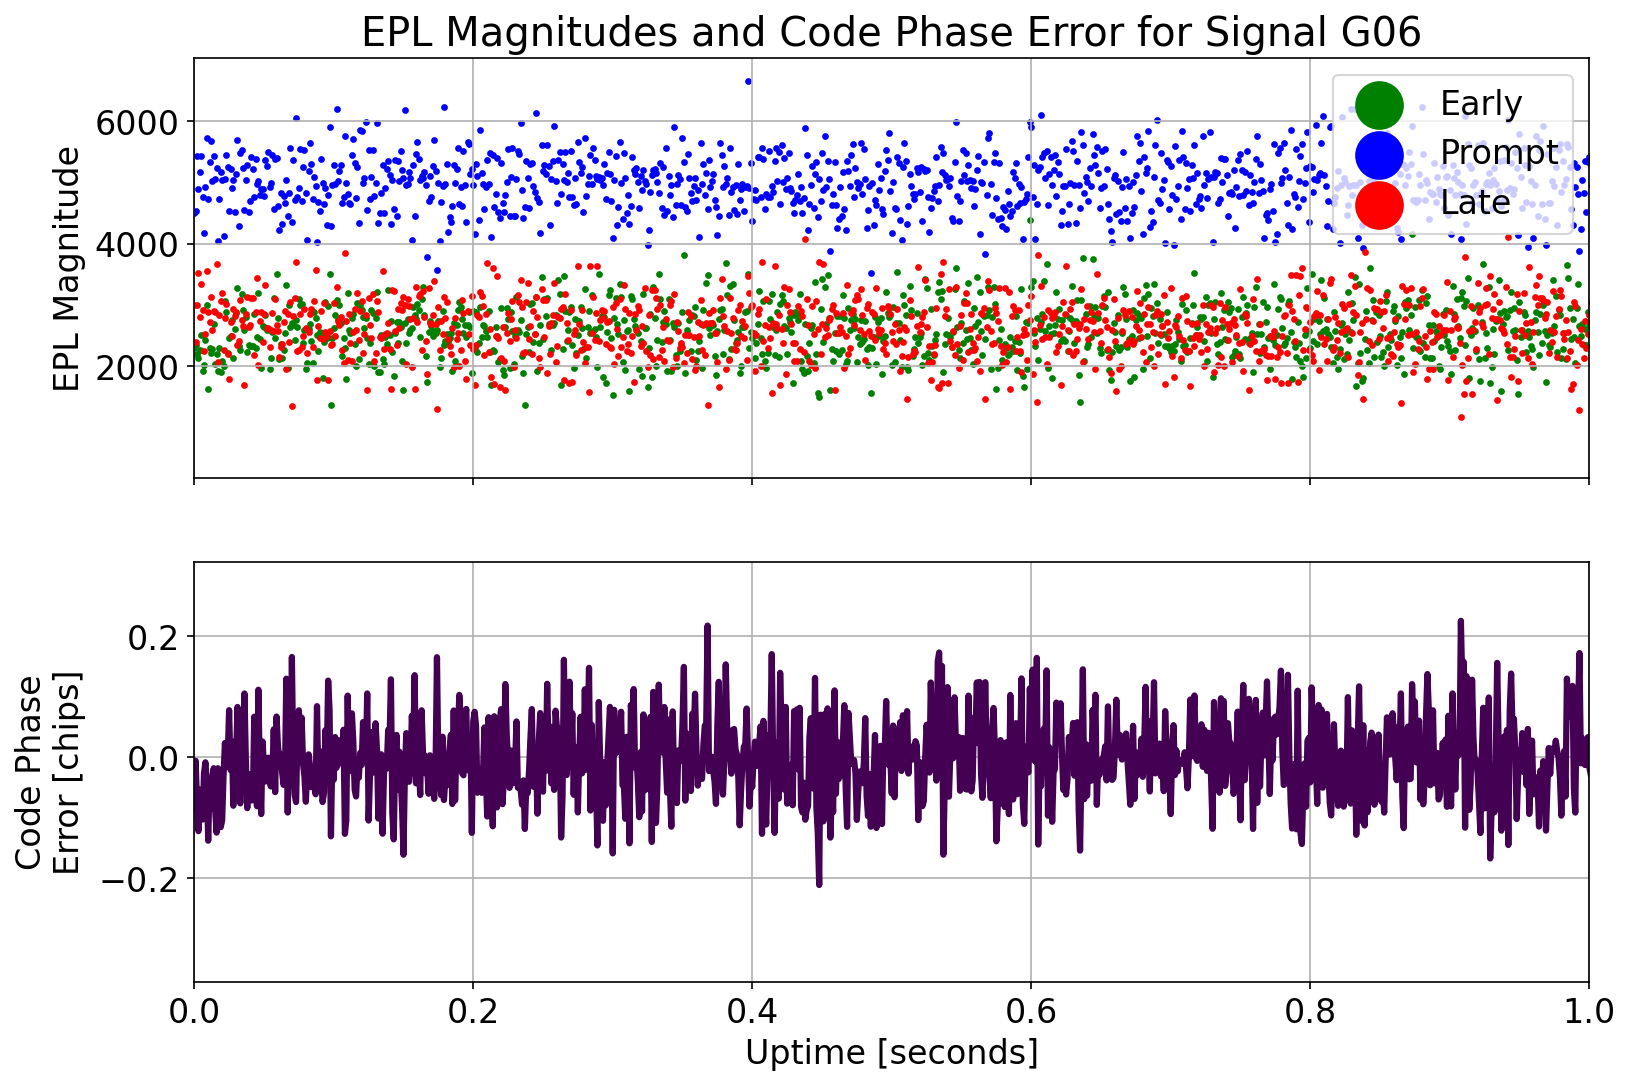

In [13]:
# Plot EPL magnitudes and code error for each tracking version
fig = plt.figure(figsize=(12, 8), dpi=150)
axes = fig.subplots(2, 1, sharex=True)
cmap = plt.get_cmap("viridis")

# tracking_version_id = "vT2_code-offset"
tracking_version_id = "v1"
tracking_loop_params = all_tracking_loop_params[tracking_version_id]
tracking_outputs = all_tracking_outputs[tracking_version_id]
tracking_output = tracking_outputs[plot_sig_id]

plot_time = tracking_output.uptime_seconds
early = tracking_output.early_corr
prompt = tracking_output.prompt_corr
late = tracking_output.late_corr
code_phase_errors_chips = tracking_output.code_phase_errors_chips

color = cmap(i / len(plot_tracking_version_ids))

# Plot EPL magnitude
ax = axes[0]
ax.scatter(plot_time, np.abs(early), color="g", s=5)
ax.scatter(plot_time, np.abs(prompt), color="b", s=5)
ax.scatter(plot_time, np.abs(late), color="r", s=5)
ax.set_ylabel("EPL Magnitude")
ax.set_title(f"EPL Magnitudes and Code Phase Error for Signal {plot_sig_id}")
ax.legend(["Early", "Prompt", "Late"], markerscale=10, loc="upper right")

# Plot code phase error
ax = axes[1]
ax.plot(plot_time, code_phase_errors_chips, color=color, lw=3)
ax.set_ylabel("Code Phase\nError [chips]")
ax.set_xlabel("Uptime [seconds]")
ax.set_xlim(0, 1)
for ax in axes:
    ax.grid()
fig.align_labels()
plt.show()